In [1]:
import os
import sys
import csv
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchmetrics.functional.image import peak_signal_noise_ratio as psnr
from torchmetrics.functional import mean_squared_error as mse
from torchmetrics.functional.image import structural_similarity_index_measure as ssim
from tqdm.notebook import tqdm
sys.path.append('../')
from datamodule.datamodule import select_data
from models.models import Classifier
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
print(plt.style.available)
plt.style.use('seaborn-v0_8-dark-palette')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
path_data = '../../data/sim2real/'
files = os.listdir(path_data)
files.sort()
train_files = [os.path.join(path_data, i) for i in files if 'train' in i]
valid_files = [os.path.join(path_data, i) for i in files if 'valid' in i]

In [4]:
data = torch.load(train_files[0], weights_only=True)

In [5]:
data.keys()

dict_keys(['resampled_sample', 'bench_image', 'sim2real_output', 'sim_output', 'target'])

## Plot the learned calibration layer

In [6]:
path_checkpoint = '../../results/sim2real/version_2/checkpoints/last.ckpt'
state_dict = torch.load(path_checkpoint, weights_only = True)['state_dict']
initial_amplitude = state_dict['dom.layers.1.modulator.initial_amplitude'].squeeze().detach().cpu().numpy()
initial_phase = state_dict['dom.layers.1.modulator.initial_phase'].squeeze().detach().cpu().numpy()
optim_amplitude = state_dict['dom.layers.1.modulator.optimizeable_amplitude'].squeeze().detach().cpu().numpy()
optim_phase = state_dict['dom.layers.1.modulator.optimizeable_phase'].squeeze().detach().cpu().numpy()

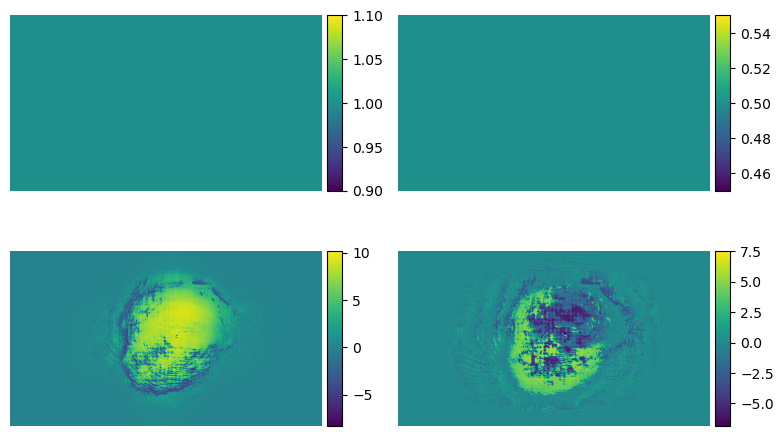

In [7]:
fig, ax = plt.subplots(2,2, figsize=(8,5))

im0 = ax[0][0].imshow(initial_amplitude)
divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

im1 = ax[0][1].imshow(initial_phase)
divider = make_axes_locatable(ax[0][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1][0].imshow(optim_amplitude)
divider = make_axes_locatable(ax[1][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

im3 = ax[1][1].imshow(optim_phase)
divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

for a in ax.flatten():
    a.axis('off')
plt.tight_layout()

## Plot 3 examples from each dataset

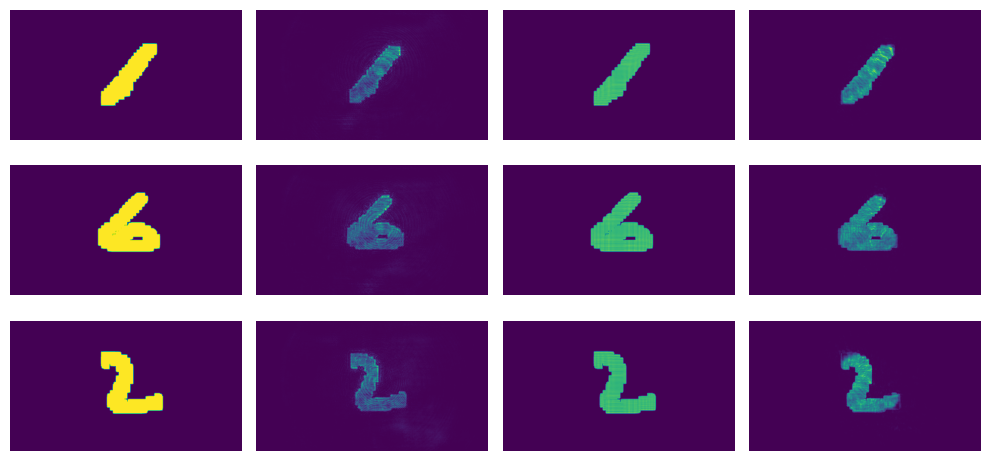

In [8]:
fig, ax = plt.subplots(3, 4, figsize = (10,5))

indices = torch.randint(low=0, high=len(train_files), size=(3,))

for j,i in enumerate(indices):
    data = torch.load(train_files[i], weights_only=True)
    ax[j][0].imshow(data['resampled_sample'].squeeze())
    ax[j][1].imshow(data['bench_image'].squeeze())
    ax[j][2].imshow(data['sim_output'].squeeze())
    ax[j][3].imshow(data['sim2real_output'].squeeze())

for a in ax.flatten():
    a.axis('off')

plt.tight_layout()

## Image metrics

In [9]:
mse_values = {'ideal_to_sim':[], 'ideal_to_bench':[], 'ideal_to_sim2real':[], 'bench_to_sim':[], 'bench_to_sim2real':[], 'sim_to_sim2real':[]}
ssim_values = {'ideal_to_sim':[], 'ideal_to_bench':[], 'ideal_to_sim2real':[], 'bench_to_sim':[], 'bench_to_sim2real':[], 'sim_to_sim2real':[]}
psnr_values = {'ideal_to_sim':[], 'ideal_to_bench':[], 'ideal_to_sim2real':[], 'bench_to_sim':[], 'bench_to_sim2real':[], 'sim_to_sim2real':[]}

for i,file in enumerate(tqdm(train_files + valid_files)):
    data = torch.load(file, weights_only=True)
    resampled_sample = data['resampled_sample'].cuda()
    bench_image = data['bench_image'].cuda().unsqueeze(0).unsqueeze(0)
    sim_output = data['sim_output'].cuda().unsqueeze(0).unsqueeze(0)
    sim2real_output = data['sim2real_output'].cuda()

    mse_ideal_to_sim = mse(resampled_sample, sim_output).cpu()
    mse_ideal_to_bench = mse(resampled_sample, bench_image).cpu()
    mse_ideal_to_sim2real = mse(resampled_sample, sim2real_output).cpu()
    mse_bench_to_sim = mse(bench_image, sim_output).cpu()
    mse_bench_to_sim2real = mse(bench_image, sim2real_output).cpu()
    mse_sim_to_sim2real = mse(sim_output, sim2real_output).cpu()

    ssim_ideal_to_sim = ssim(resampled_sample, sim_output).cpu()
    ssim_ideal_to_bench = ssim(resampled_sample, bench_image).cpu()
    ssim_ideal_to_sim2real = ssim(resampled_sample, sim2real_output).cpu()
    ssim_bench_to_sim = ssim(bench_image, sim_output).cpu()
    ssim_bench_to_sim2real = ssim(bench_image, sim2real_output).cpu()
    ssim_sim_to_sim2real = ssim(sim_output, sim2real_output).cpu()

    psnr_ideal_to_sim = psnr(resampled_sample, sim_output).cpu()
    psnr_ideal_to_bench = psnr(resampled_sample, bench_image).cpu()
    psnr_ideal_to_sim2real = psnr(resampled_sample, sim2real_output).cpu()
    psnr_bench_to_sim = psnr(bench_image, sim_output).cpu()
    psnr_bench_to_sim2real = psnr(bench_image, sim2real_output).cpu()
    psnr_sim_to_sim2real = psnr(sim_output, sim2real_output).cpu()

    mse_values['ideal_to_sim'].append(mse_ideal_to_sim)
    mse_values['ideal_to_bench'].append(mse_ideal_to_bench)
    mse_values['ideal_to_sim2real'].append(mse_ideal_to_sim2real)
    mse_values['bench_to_sim'].append(mse_bench_to_sim)
    mse_values['bench_to_sim2real'].append(mse_bench_to_sim2real)
    mse_values['sim_to_sim2real'].append(mse_sim_to_sim2real)

    ssim_values['ideal_to_sim'].append(ssim_ideal_to_sim)
    ssim_values['ideal_to_bench'].append(ssim_ideal_to_bench)
    ssim_values['ideal_to_sim2real'].append(ssim_ideal_to_sim2real)
    ssim_values['bench_to_sim'].append(ssim_bench_to_sim)
    ssim_values['bench_to_sim2real'].append(ssim_bench_to_sim2real)
    ssim_values['sim_to_sim2real'].append(ssim_sim_to_sim2real)

    psnr_values['ideal_to_sim'].append(psnr_ideal_to_sim)
    psnr_values['ideal_to_bench'].append(psnr_ideal_to_bench)
    psnr_values['ideal_to_sim2real'].append(psnr_ideal_to_sim2real)
    psnr_values['bench_to_sim'].append(psnr_bench_to_sim)
    psnr_values['bench_to_sim2real'].append(psnr_bench_to_sim2real)
    psnr_values['sim_to_sim2real'].append(psnr_sim_to_sim2real)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
# Clean up the values

for key,value in mse_values.items():
    array = value
    array = [i.numpy() for i in array]
    mse_values[key] = np.asarray(array)

for key,value in ssim_values.items():
    array = value
    array = [i.numpy() for i in array]
    ssim_values[key] = np.asarray(array)

for key,value in psnr_values.items():
    array = value
    array = [i.numpy() for i in array]
    psnr_values[key] = np.asarray(array)

## Violin plots now

Text(0, 0.5, 'MSE')

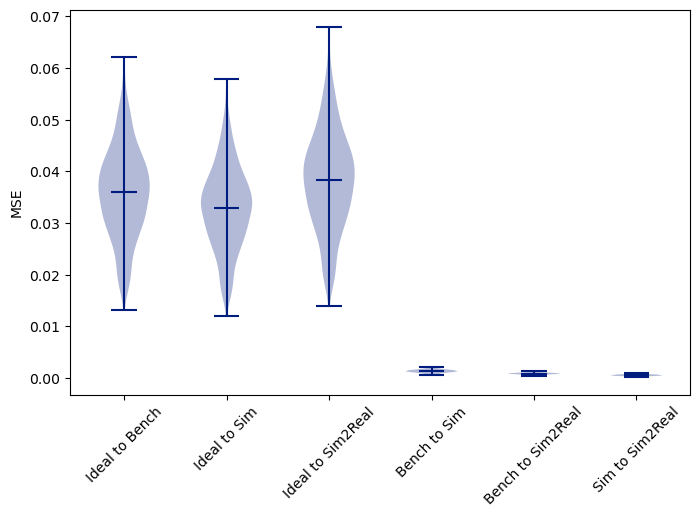

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
labels = ['Ideal to Bench', 'Ideal to Sim', 'Ideal to Sim2Real', 'Bench to Sim', 'Bench to Sim2Real', 'Sim to Sim2Real']


bp0 = ax.violinplot([mse_values['ideal_to_bench'], 
                     mse_values['ideal_to_sim'], 
                     mse_values['ideal_to_sim2real'], 
                     mse_values['bench_to_sim'], 
                     mse_values['bench_to_sim2real'],
                     mse_values['sim_to_sim2real']], 
                     points=1000, showmeans=True)


ax.set_xticks([i+1 for i in range(len(labels))], labels, rotation=45)
ax.set_ylabel("MSE")

Text(0, 0.5, 'SSIM')

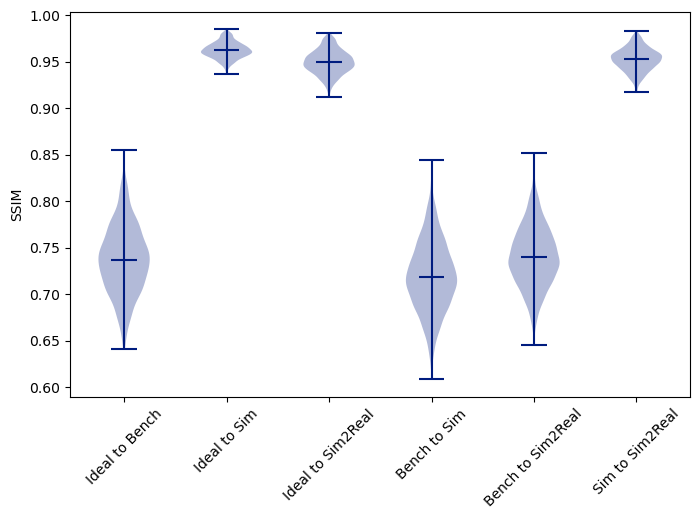

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
labels = ['Ideal to Bench', 'Ideal to Sim', 'Ideal to Sim2Real', 'Bench to Sim', 'Bench to Sim2Real', 'Sim to Sim2Real']


bp0 = ax.violinplot([ssim_values['ideal_to_bench'], 
                     ssim_values['ideal_to_sim'], 
                     ssim_values['ideal_to_sim2real'], 
                     ssim_values['bench_to_sim'], 
                     ssim_values['bench_to_sim2real'],
                     ssim_values['sim_to_sim2real']], 
                     points=1000, showmeans=True)


ax.set_xticks([i+1 for i in range(len(labels))], labels, rotation=45)
ax.set_ylabel("SSIM")

Text(0, 0.5, 'PSNR')

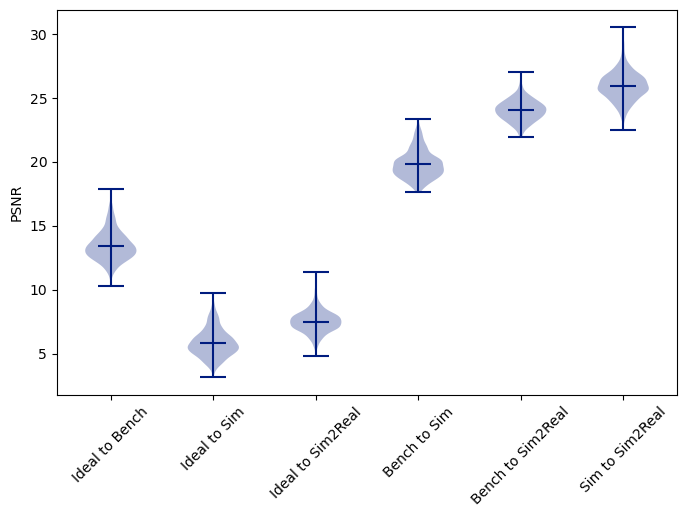

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
labels = ['Ideal to Bench', 'Ideal to Sim', 'Ideal to Sim2Real', 'Bench to Sim', 'Bench to Sim2Real', 'Sim to Sim2Real']


bp0 = ax.violinplot([psnr_values['ideal_to_bench'], 
                     psnr_values['ideal_to_sim'], 
                     psnr_values['ideal_to_sim2real'], 
                     psnr_values['bench_to_sim'], 
                     psnr_values['bench_to_sim2real'],
                     psnr_values['sim_to_sim2real']], 
                     points=1000, showmeans=True)


ax.set_xticks([i+1 for i in range(len(labels))], labels, rotation=45)
ax.set_ylabel("PSNR")